## Import Packages

In [83]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

## Import File and Run Diagnosis

In [84]:
df = pd.read_csv('retentiondata_case.csv' )
print(df.shape)
print(df.describe(include='all'))
print(df['left_flag'].value_counts())# summary stats
missing_counts = df.isnull().sum()
missing_counts

(5636, 36)
          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         5636          5636           5636  5636.000000       5636   
unique        5621          5636              2          NaN          2   
top     ACCT426225  CUST55166391             No          NaN        Yes   
freq             2             1           3957          NaN       5079   
mean           NaN           NaN            NaN    32.445174        NaN   
std            NaN           NaN            NaN    24.515986        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    29.000000        NaN   
75%            NaN           NaN            NaN    55.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        5636      

acct_ref                    0
cust_ref                    0
has_dependents              0
tenure_mo                   0
home_phone                  0
multi_line                  0
internet_plan               0
add_on_security             0
add_on_backup               0
add_on_protection           0
tech_support_std            0
stream_tv                   0
stream_movies               0
contract_term               0
e_bill_opt_in               0
pay_method                  0
monthly_fee                 0
total_billed                8
left_flag                   0
fiscal_qtr                  0
gender                      0
age_years                   0
is_married                  0
dependents_count            0
referred_friend             0
referrals_count             0
recent_offer             3106
avg_long_dist_fee           0
internet_tech            1212
avg_gb_download             0
premium_support             0
stream_music                0
unlimited_data_opt          0
refunds_to

## Prediction Value

In [85]:
print(df["left_flag"].dtype)                     
print(df["left_flag"].unique())   

object
['No' 'Yes']


## Drop Unnecessary Columns

In [86]:
df= df.drop(columns=["acct_ref","cust_ref"])

# drop rows wiht missing total billed, brand new customers with no bills yet
df = df.dropna(subset=["total_billed"])

## Standardize string columns

In [87]:
str_cols = ["internet_plan", "internet_tech", "recent_offer", "contract_term", "pay_method", "gender", "fiscal_qtr", "left_flag", "multi_line"]
for x in str_cols:
    if x in df.columns:
        df[x] = df[x].astype("string").str.strip()

## Fill in Missing values

In [88]:
df["recent_offer"]  = df["recent_offer"].fillna("none")
df["internet_tech"]  = df["internet_tech"].fillna("none")
df["internet_plan"]  = df["internet_plan"].fillna("none")

## Change all variants of not No to none to consildate them to one category

In [89]:
df["internet_plan"] = df["internet_plan"].replace({"None": "none", "No": "none", "No internet service": "none"})
df["internet_tech"] = df["internet_tech"].replace({"None": "none", "No": "none", "No internet service": "none"})
df["recent_offer"]  = df["recent_offer"].replace({"None": "none", "No": "none"})

## Make sure all numeric columns are numeric

In [90]:
num_cols = [
    "tenure_mo", "monthly_fee", "total_billed",
    "extra_data_fees_total", "long_dist_fees_total",
    "avg_gb_download"
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

## Convert Yes/No columns to 1/0 so model can use these variables numerically 

In [91]:
yes_no_cols = [
    "has_dependents","home_phone","add_on_security","add_on_backup",
    "add_on_protection","tech_support_std","stream_tv","stream_movies",
    "e_bill_opt_in","is_married","referred_friend","premium_support",
    "stream_music","unlimited_data_opt"
]

for x in yes_no_cols:
    if x in df.columns:
        df[x] = df[x].map({"Yes": 1, "No": 0})


## Handle Multi Line having 3 Answers

In [92]:
if "multi_line" in df.columns:
    ml = df["multi_line"].fillna("No").astype("string").str.strip()
    df["multi_line_flag"] = (ml == "Yes").astype(int)
    df["no_phone_service"] = (ml == "No phone service").astype(int)
    df = df.drop(columns=["multi_line"])
else:
    df["multi_line_flag"] = 0
    df["no_phone_service"] = 0

## Set x and y variables for model

In [93]:
Y = (df["left_flag"] == "Yes").astype(int)
X = df.drop(columns=["left_flag"])

## Adding Average Columns

In [94]:
# had to do this so dividing that the code would not divide by zero
X["tenure_mo_nonzero"] = X["tenure_mo"].clip(lower=1)

# average monthly billed
X["avg_monthly_billed"] = X["total_billed"] / X["tenure_mo_nonzero"]

# average extra data fees
X["avg_monthly_extra_data_fees"] = X["extra_data_fees_total"] / X["tenure_mo_nonzero"]

# average long distance fees
X["avg_monthly_long_dist_fees"] = X["long_dist_fees_total"] / X["tenure_mo_nonzero"]

## Counting of base services, streaming services, and add on services

In [95]:
# Internet present flag (clean because internet_plan uses 'none')
X["has_internet"] = (X["internet_plan"] != "none").astype(int)

# categorizes streaming and add on services
stream_cols = ["stream_tv", "stream_movies", "stream_music"]
addon_cols = ["add_on_security", "add_on_backup", "add_on_protection", "premium_support", "unlimited_data_opt"]

# Counts regualr services
X["count_of_reg_services"] = X["home_phone"] + X["multi_line_flag"] + X["has_internet"]

# counts streaming services
X["count_of_streaming_services"] = X[stream_cols].sum(axis=1)

# counts add on services
X["count_of_add_on_services"] = X[addon_cols].sum(axis=1)

#counts total services 
X["total_services"] = X["count_of_reg_services"] + X["count_of_streaming_services"] + X["count_of_add_on_services"]


## Early Tenure and Interaction term of being month to month and early tenure

In [96]:
# We included an interaction between early tenure and month-to-month contracts because customers 
# who are both new and not contractually locked in represent the highest churn risk.
X["is_month_to_month"] = (X["contract_term"] == "month-to-month").astype(int)
X["early_tenure"] = (X["tenure_mo"] <= 6).astype(int)
X["early_mtm"] = X["is_month_to_month"] * X["early_tenure"]

## Test Train Split

In [98]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     
    random_state=45,   # reproducibility
    shuffle=True,       # shuffle before splitting
    stratify=Y         # churn is ibalanced so stratifying this insures proportion of churn is consistent
)

# Check shapes
X_train.shape, X_test.shape

((3939, 46), (1689, 46))

## Pipeline

In [99]:
# Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Helps weight the data when churn % is imballenced
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()

# Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="warn", sparse_output=False))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False   # drops the num and cat prefixs to variables
)

## Model

In [101]:
# Stratified CV preserves class balance in each fold (important for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)


# Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        n_jobs=2,          # use all cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=99,
        scale_pos_weight=scale_pos_weight   #applies class weighting since churn cases are more rare causing misclassifying a churned customer carries a higher penalty
    ))
])

#  Hyperparameter grid (more parameters here: https://federated-xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
param_grid = {
    "model__n_estimators": [400, 800],
    "model__max_depth":    [4, 6, 8],
    "model__learning_rate":[0.05, 0.1],
    "model__subsample":    [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__min_child_weight": [1, 3]
}

#  Cross-validated grid search (same scoring)
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

# Fit 
xgb_cv.fit(X_train, Y_train)


print("Best params selected by CV:", xgb_cv.best_params_)
print("Best CV ROC-AUC:", round(xgb_cv.best_score_, 3))

Best params selected by CV: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__subsample': 1.0}
Best CV ROC-AUC: 0.897


## Testing for AUC

In [102]:
y_proba = xgb_cv.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(Y_test, y_proba)
print("Test ROC-AUC:", round(test_auc, 4))

Test ROC-AUC: 0.8928


## Top Features

contract_term_Month-to-month    0.228658
contract_term_Two year          0.101513
internet_plan_Fiber optic       0.082743
referrals_count                 0.051376
pay_method_Electronic check     0.040528
has_dependents                  0.036265
referred_friend                 0.030669
stream_movies                   0.029928
dependents_count                0.025935
contract_term_One year          0.020630
tenure_mo                       0.019987
count_of_reg_services           0.018617
is_married                      0.016976
count_of_streaming_services     0.015785
pay_method_Mailed check         0.015341
dtype: float32

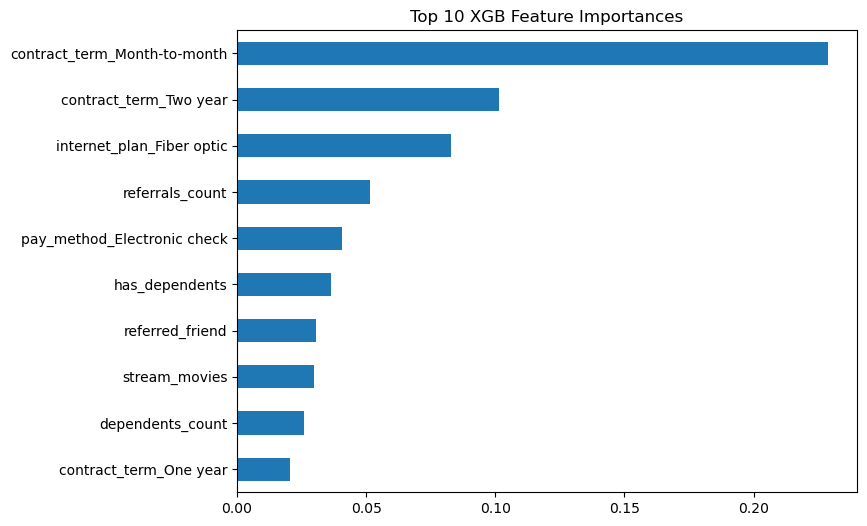

In [103]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

#get important features
pre = xgb_cv.best_estimator_.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()
imp = pd.Series(best_xgb.feature_importances_, index=feature_names).sort_values(ascending=False)

display(imp.head(15))  # top 10 features


# Optional: plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
imp.head(10).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 10 XGB Feature Importances")
plt.gca().invert_yaxis()
plt.show()

## SHAP Values

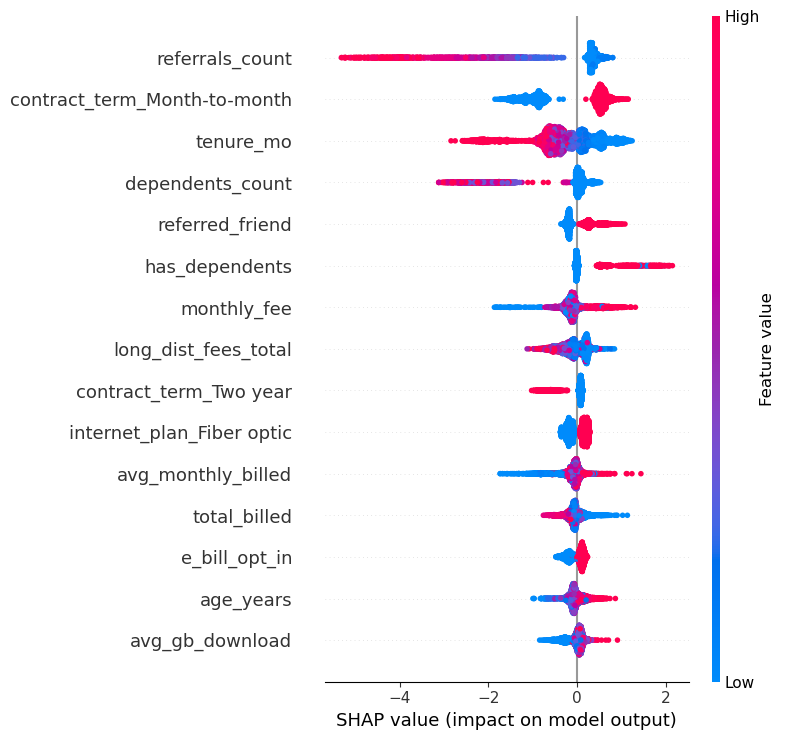

In [104]:
import shap                  

pre = xgb_cv.best_estimator_.named_steps["preprocess"]

#  Transform X the same way the model saw it
X_train_enc = pre.transform(X_train)

#  Get feature names after preprocessing (works for ColumnTransformer / Pipeline in sklearn >= 1.0)
feature_names = None
if hasattr(pre, "get_feature_names_out"):
    feature_names = pre.get_feature_names_out()
    
# Create SHAP explainer for tree-based models (e.g., XGBoost, LightGBM, RandomForest)
explainer   = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the training set
# Each value shows how much a feature pushes a prediction toward class 1 (positive) or class 0 (negative)
shap_values = explainer.shap_values(X_train_enc)

# Overall PLot Beeswarm plot: this shows both which features matter most and the direction of their influence

shap.summary_plot(shap_values, X_train_enc, max_display=15, show=True,feature_names=feature_names)

## list of variables

In [82]:
X.head()

,has_dependents,tenure_mo,home_phone,internet_plan,add_on_security,add_on_backup,add_on_protection,tech_support_std,stream_tv,stream_movies,...,avg_monthly_extra_data_fees,avg_monthly_long_dist_fees,has_internet,count_of_reg_services,count_of_streaming_services,count_of_add_on_services,total_services,is_month_to_month,early_tenure,early_mtm
0,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00,1,1,0.0,2.0,3.0,0,1,0
1,0,34,1,DSL,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,17.09,1,2,0.0,3.0,5.0,0,0,0
2,0,2,1,DSL,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,10.47,1,2,0.0,3.0,5.0,0,1,0
3,0,45,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.00,1,1,0.0,4.0,5.0,0,0,0
4,0,2,1,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.12,1,2,0.0,1.0,3.0,0,1,0


## Dependence Plots

In [81]:
#Dependence plot for one feature
shap.dependence_plot("early_mtm", shap_values, X_train_enc, interaction_index="early_mtm"), show=True,feature_names=feature_names)

# Dependence plot for one feature, colored by another feature
shap.dependence_plot("total_services", shap_values, X_train_enc, interaction_index="has_internet", show=True,feature_names=feature_names)

ValueError: Could not find feature named: early_mtm)

## Testing ROC-AUC

In [ ]:
Ytest_prob = xgb_cv.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

test_auc = roc_auc_score(Y_test, Ytest_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Ytest_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()